In [50]:
import sqlite3
import statistics
import matplotlib.pyplot as plt
import requests
import json
from mpl_toolkits.basemap import Basemap
import numpy as np

conn = sqlite3.connect('songs.db')

cursor = conn.cursor()

In [55]:
def getIndicators():
    cursor.execute(
        '''
            PRAGMA table_info(indicator_set);
        '''
    )
    columns = cursor.fetchall()
    columns = np.array(columns)[1:,1]
    return columns
def calcMedianSentiment():
    medianLyricSentiment = {}
    cursor.execute(
        '''
        SELECT sampleID, country FROM sample;
        '''
    )
    samples = cursor.fetchall()
    for sampleID, country in samples:
        if not country in medianLyricSentiment:
            medianLyricSentiment[country] = []
        
        cursor.execute(
            '''
            SELECT songID FROM sample_song
            WHERE sampleID = ?
            ''', (sampleID,)
        )
        songIDs = cursor.fetchall()
        for songID in songIDs:
            cursor.execute(
                '''
                SELECT lyric_sentiment FROM song
                WHERE songID = ?;
                ''', (songID)
            )
            lyric_sentiment = cursor.fetchone()
            if lyric_sentiment is not None and lyric_sentiment[0] is not None:
                medianLyricSentiment[country].append(lyric_sentiment[0])
    noneKeys = []
    for country in medianLyricSentiment:
        if len(medianLyricSentiment[country]):
            medianLyricSentiment[country] = statistics.median(medianLyricSentiment[country])
        else:
            noneKeys.append(country)
    for country in noneKeys:
        del medianLyricSentiment[country]
    return medianLyricSentiment

def getIndicatorDict(indicator):
    indicatorDict = {}
    cursor.execute(
        '''
        SELECT sampleID, country FROM sample;
        '''
    )
    samples = cursor.fetchall()
    for sampleID, country in samples:
        if not country in indicatorDict:
            indicatorDict[country] = []
        cursor.execute(
            f'''
            SELECT {indicator} FROM indicator_set
            WHERE sampleID = ?
            ''', (sampleID,)
        )
        indicatorValue = cursor.fetchone()
        if indicatorValue is not None and indicatorValue[0] is not None:
            indicatorDict[country].append(indicatorValue[0])
    noneKeys = []
    for country in indicatorDict:
        if indicatorDict[country] is not None and len(indicatorDict[country]):
            indicatorDict[country] = statistics.median(indicatorDict[country])
        else:
            noneKeys.append(country)
    for country in noneKeys:
        del indicatorDict[country]
    return indicatorDict

def standardizeDict(dict):
    dictMin = min(dict.values())
    dictMax = max(dict.values())
    for country in dict:
        dict[country] = (dict[country] - dictMin) / (dictMax - dictMin)
    return dict


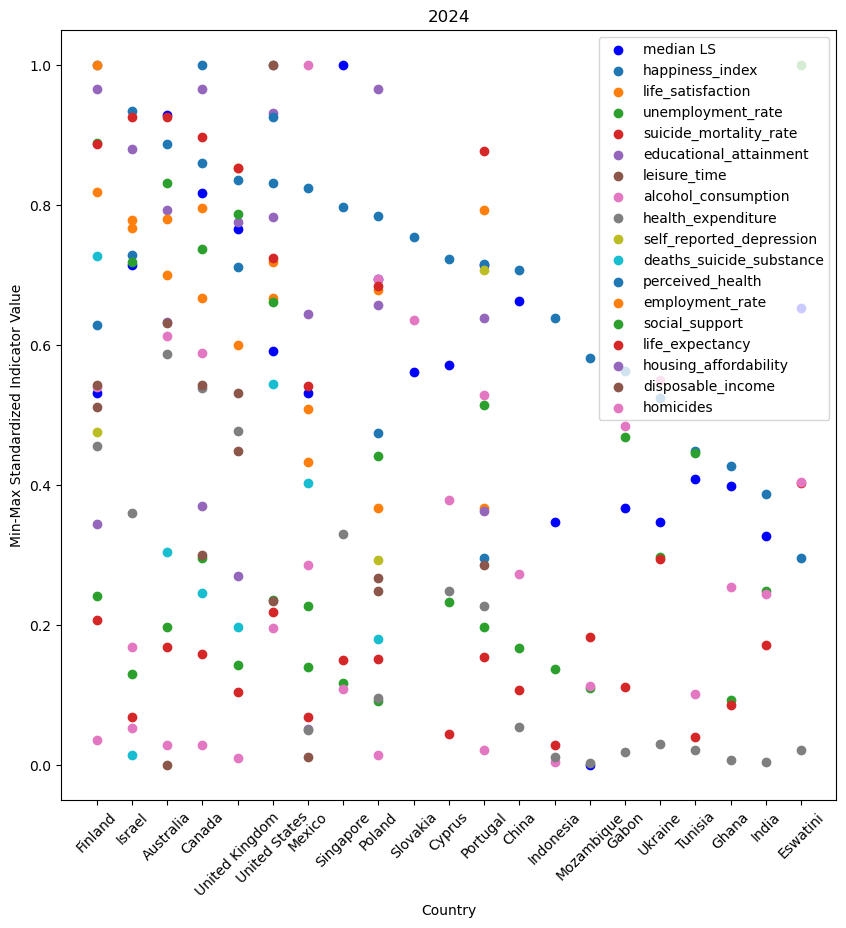

In [56]:
fig, axs = plt.subplots(1, 1, figsize=(10, 10))
plt.xticks(rotation=45)

axs.set_title("2024")
axs.set_ylabel("Min-Max Standardized Indicator Value")
axs.set_xlabel("Country")

medianLyricSentiment = standardizeDict(calcMedianSentiment())
axs.scatter(medianLyricSentiment.keys(), medianLyricSentiment.values(), color='blue', label="median LS")

indicators = getIndicators()

for index, indicator in enumerate(indicators):
    X_indicator = standardizeDict(getIndicatorDict(indicator))
    X_indicator = {k: X_indicator[k] for k in X_indicator if k in medianLyricSentiment}
    axs.scatter(X_indicator.keys(), X_indicator.values(), label=indicator)

plt.legend()
plt.show()

In [17]:
response = requests.get("https://ghoapi.azureedge.net/api/Indicator?$filter=contains(IndicatorName,'substance')")
response = requests.get("https://ghoapi.azureedge.net/api/RSUD_11")

data = response.json()
print(json.dumps(data, indent=4))

{
    "@odata.context": "https://ghoapi.azureedge.net/api/$metadata#RSUD_11",
    "value": [
        {
            "Id": 4440879,
            "IndicatorCode": "RSUD_11",
            "SpatialDimType": "COUNTRY",
            "SpatialDim": "NIC",
            "ParentLocationCode": "AMR",
            "TimeDimType": "YEAR",
            "ParentLocation": "Americas",
            "Dim1Type": "SUBSTANCETYPE",
            "Dim1": "SUBSTANCETYPE_ALCOHOL",
            "TimeDim": 2008,
            "Dim2Type": null,
            "Dim2": null,
            "Dim3Type": null,
            "Dim3": null,
            "DataSourceDimType": null,
            "DataSourceDim": null,
            "Value": "yes",
            "NumericValue": null,
            "Low": null,
            "High": null,
            "Comments": null,
            "Date": "2013-06-11T14:15:34+02:00",
            "TimeDimensionValue": "2008",
            "TimeDimensionBegin": "2008-01-01T00:00:00+01:00",
            "TimeDimensionEnd": "2008-12

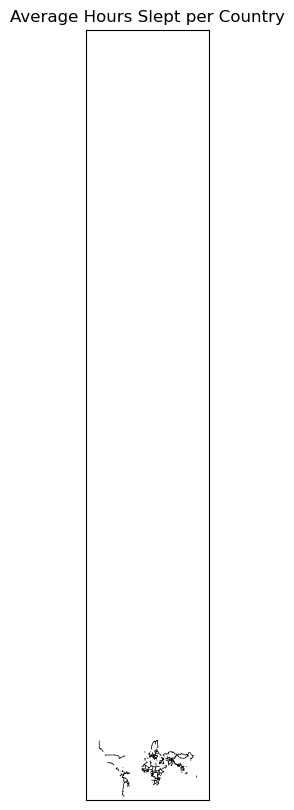

In [46]:
plt.figure(figsize=(16, 10))
m = Basemap(projection='merc', llcrnrlat=-60, urcrnrlat=90,
              llcrnrlon=-180, urcrnrlon=180, lat_ts=20)

m.drawcountries()
# m.drawmapboundary(fill_color='lightblue')
# m.fillcontinents(color='lightgreen', lake_color='lightblue')
# for index, row in df.iterrows():
#     x, y = m(row['Country lon'], row['Country lat'])  # Replace with actual lon/lat
#     plt.scatter(x, y, s=row['Metric']*10, alpha=0.5)  # Scale bubble size
plt.title('Average Hours Slept per Country')
plt.show()
